# Event detection and classification (rain versus irrigation)

**License:** CC-BY-4.0  
**Github:** [https://github.com/BenjMy/centum](https://github.com/BenjMy/centum)  
**Subject:** Tutorial
**Authors**:

Benjamin Mary
  Email: [benjamin.mary@ica.csic.es](mailto:benjamin.mary@ica.csic.es)  
  ORCID: [0000-0001-7199-2885](https://orcid.org/0000-0001-7199-2885)  
  Affiliation: ICA-CSIC
  
**Date:** 2025/01/10

In [1]:
import numpy as np
import pooch
import xarray as xr
import centum
import matplotlib.pyplot as plt
import july
from july.utils import date_range
import pandas as pd

In [2]:
from centum import plotting as pltC
from centum.delineation import ETAnalysis

## Open datasets

In [3]:
pooch_Majadas = pooch.create(
    path=pooch.os_cache("AQUACROP_project"),
    base_url="https://github.com/BenjMy/test_AQUACROP_centum_dataset/raw/refs/heads/main/AQUACROP/",
    registry={
        "EO_scenario_AquaCrop_sc7_weather_reference.netcdf": None,
        "baseline_scenario_AquaCrop_sc7_weather_reference.netcdf": None,
        "grid_xr_EO_AquaCrop_sc7_weather_reference.netcdf": None,
    },
)

filename = pooch_Majadas.fetch('EO_scenario_AquaCrop_sc7_weather_reference.netcdf')
EO_scenario_AquaCrop_sc7_weather_reference_EO_ds = xr.load_dataset(filename)
EO_scenario_AquaCrop_sc7_weather_reference_EO_ds = EO_scenario_AquaCrop_sc7_weather_reference_EO_ds.isel(time=slice(1,100))

filename = pooch_Majadas.fetch('baseline_scenario_AquaCrop_sc7_weather_reference.netcdf')
baseline_scenario_AquaCrop_sc7_weather_reference_ds = xr.load_dataset(filename)

filename = pooch_Majadas.fetch('grid_xr_EO_AquaCrop_sc7_weather_reference.netcdf')
irrigation_districts_grid = xr.load_dataset(filename)
irrigation_districts_grid

<xarray.Dataset> Size: 1MB
Dimensions:         (x: 10, y: 10, time: 366, time_hours: 8784)
Coordinates:
  * x               (x) int64 80B 0 100 200 300 400 500 600 700 800 900
  * y               (y) int64 80B 0 100 200 300 400 500 600 700 800 900
  * time            (time) timedelta64[ns] 3kB 0 days 1 days ... 365 days
  * time_hours      (time_hours) int64 70kB 0 1 2 3 4 ... 8780 8781 8782 8783
Data variables:
    DEM             (x, y) float64 800B 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 0.999
    irrigation_map  (x, y) float64 800B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ETp_daily       (time, x, y) float64 293kB 1.794e-08 1.794e-08 ... 0.0 0.0
    irr_daily       (time, x, y) float64 293kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rain_daily      (time, x, y) float64 293kB 0.0 0.0 ... 8.183e-08 8.183e-08
    net_atmbc       (time, x, y) float64 293kB -1.794e-08 ... 8.183e-08

### Show Earth Observation time serie to analyse

## Irrigation delineation

In [4]:
scenario_analysis_usingET = ETAnalysis()
decision_ds, event_type = scenario_analysis_usingET.irrigation_delineation(EO_scenario_AquaCrop_sc7_weather_reference_EO_ds)
dates_dt = [pd.to_datetime(date).to_pydatetime() for date in decision_ds.datetime.values]

## Show 2d result

In [5]:
event_type_node_IN = event_type.mean(['x','y'])
reference_date = pd.Timestamp("2025-01-01")
datetime = pd.to_datetime(reference_date + event_type_node_IN.time)

<Axes: title={'center': 'Rain (mm/h)'}>

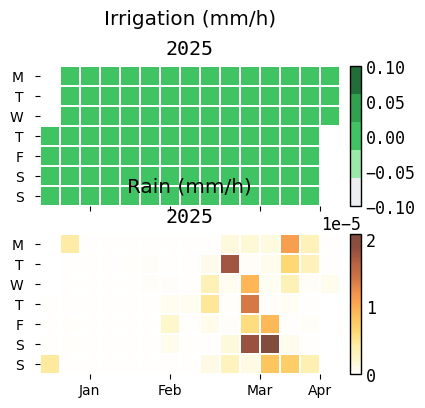

In [6]:
fig, axs = plt.subplots(2,1,sharex=True,figsize=(7,4))

july.heatmap(datetime, 
             irrigation_districts_grid['irr_daily'].sum(['x','y']), 
             title='Irrigation (mm/h)',
             cmap="github",
             colorbar=True,
             ax=axs[0]
             )
july.heatmap(datetime, 
             irrigation_districts_grid['rain_daily'].sum(['x','y']), 
             title='Rain (mm/h)',
             cmap="golden",
             colorbar=True,
             ax=axs[1]
             )

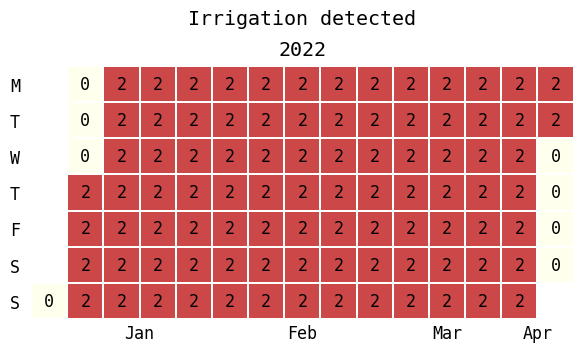

In [7]:

fig, ax = plt.subplots(figsize=(7,4))

im = july.heatmap(dates_dt, 
              event_type_node_IN.values, 
              title='Irrigation detected',
              # cmap=white_cmap,
              ax=ax,
              linewidth=1, 
              value_label=True,
              )